In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-11-09 21:46:48.809157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 21:46:49.031200: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-09 21:46:49.043971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 21:46:49.043983: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'scMNC-Visual'
dataset_color = 'magenta'
modality_names = ['Gene Expression', 'Electrophysiology']
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_filtered.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
feature_names1 = data1.iloc[:,0]
feature_names2 = data2.columns[3:]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/20200711_patchseq_metadata_mouse.csv")[['transcriptomics_sample_id', 't_type']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split(' ')[0] for x in meta[meta_idx, 1]])

# Sampling
# split = 1000 # data1.shape[0]
# data_col_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
# data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]
features = [np.array(feature_names1), np.array(feature_names2)]
feature_dict = {}

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32

# JAMIE

In [7]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
    'dropout': 0,
}
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = 'saved_models/jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)

Loaded model 'saved_models/jm---scMNC-Visual---3654-1302---3654-39---batch_size-512--dist_method-euclidean--dropout-0--epoch_DNN-10000--log_DNN-500--loss_weights-(1-1-1-1)--min_epochs-2500--output_dim-32--pca_dim-(512-512)--use_early_stop-True.h5'


In [8]:
# Imputation
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = 'saved_models/jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model 'saved_models/jm_im---scMNC-Visual---3654-1302---3654-39---batch_size-512--dist_method-euclidean--epoch_DNN-10000--log_DNN-500--loss_weights-(1-1-1-1)--min_epochs-2500--output_dim-32--pca_dim-(512-512)--use_early_stop-True.h5'


# Comparison Methods

In [9]:
integrated_data = [jm_data]
integrated_names = ['JAMIE']
colors = ['blue']
shapes = ['8']

In [10]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        dataset_mini[i] = pca.fit_transform(dataset[i])
        # dataset_mini[i] = np.zeros((dataset[i].shape[0], n_components))
        pca_mini.append(pca)

In [11]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/NLMA---scMNC-Visual---3654-1302---3654-39.npy'


In [12]:
method_name, method_color, method_shape = 'LMA', 'orange', '*'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/LMA---scMNC-Visual---3654-1302---3654-39.npy'


In [13]:
method_name, method_color, method_shape = 'CCA', 'm', 'D'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/CCA---scMNC-Visual---3654-1302---3654-39.npy'


In [14]:
method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
in_data = dataset
in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
in_data = [np.matmul(d, d.T) for d in in_data]
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/MMD-MA---scMNC-Visual---3654-3654---3654-3654.npy'


In [15]:
method_name, method_color, method_shape = 'UnionCom', 'green', 's'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/UnionCom---scMNC-Visual---3654-1302---3654-39.npy'


In [16]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [17]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [18]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig('./output_figures/' + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig('./output_figures/' + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

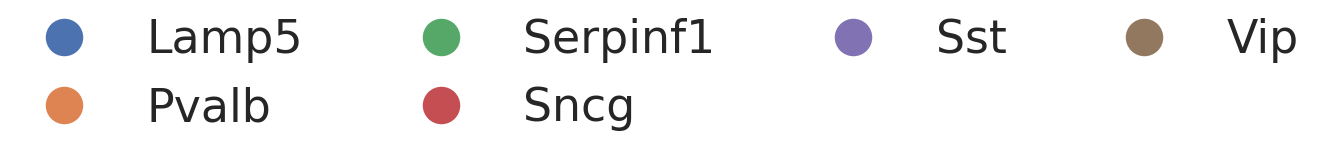

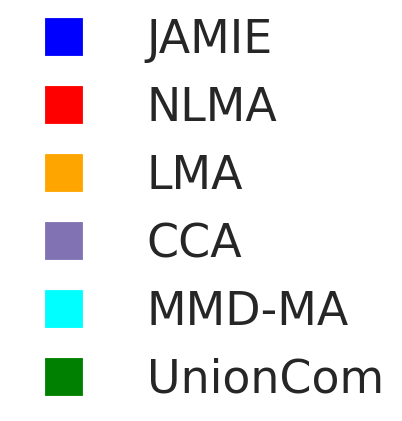

In [19]:
from IPython.display import display, Image
display( Image(filename='./output_figures/' + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename='./output_figures/' + dataset_name + '-AlgorithmLegend.png', width=100) )

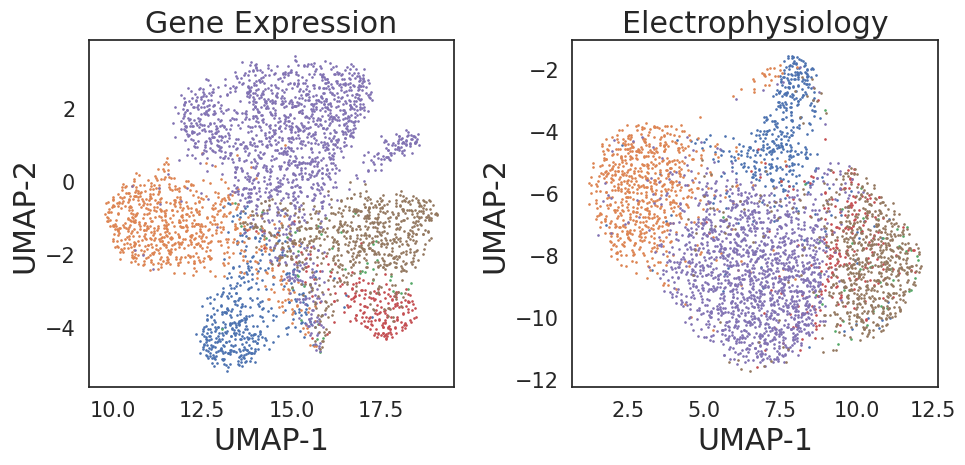

In [20]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')

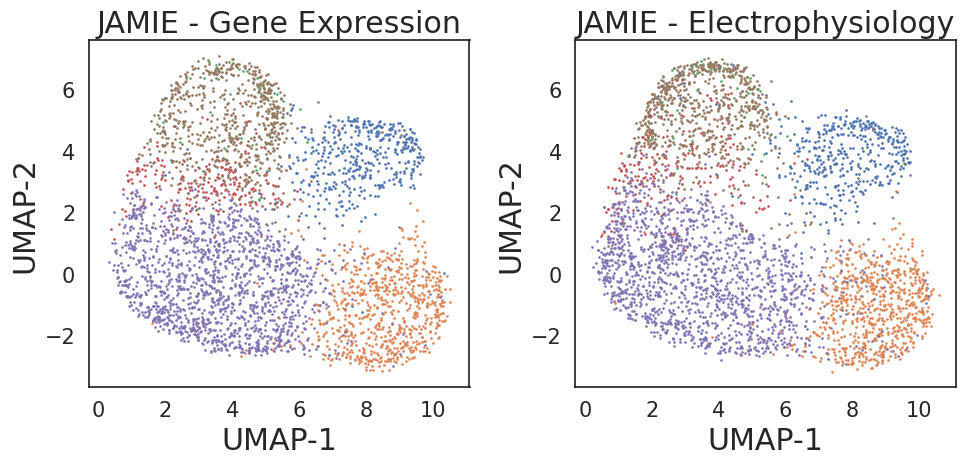

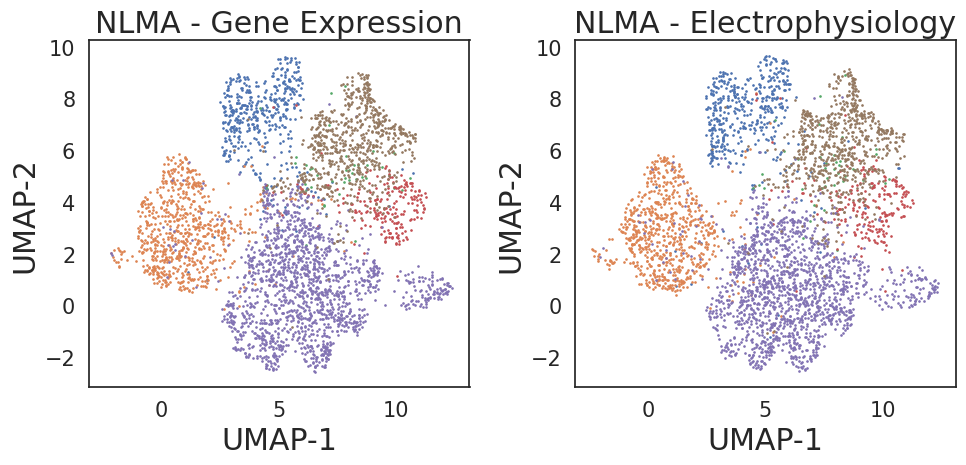

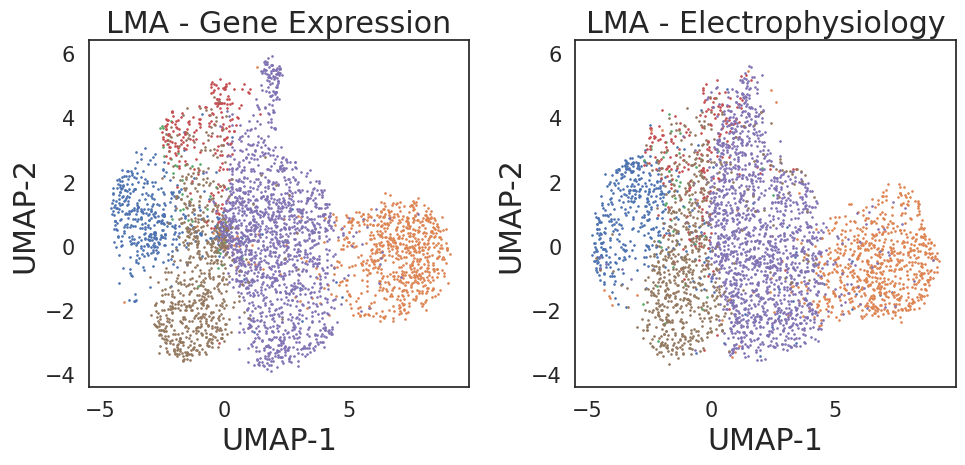

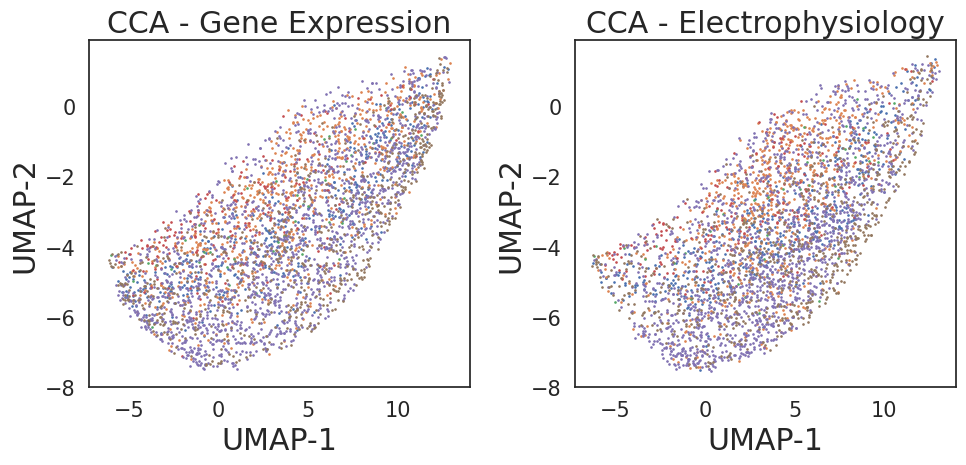

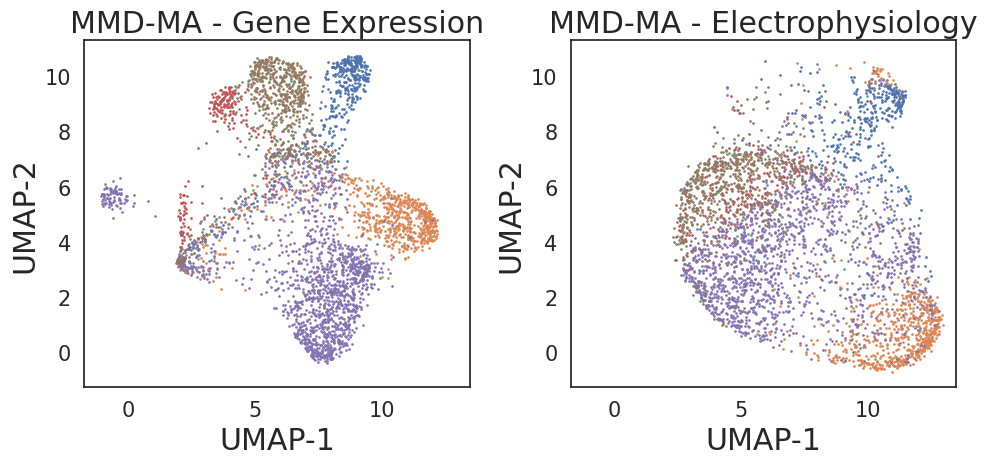

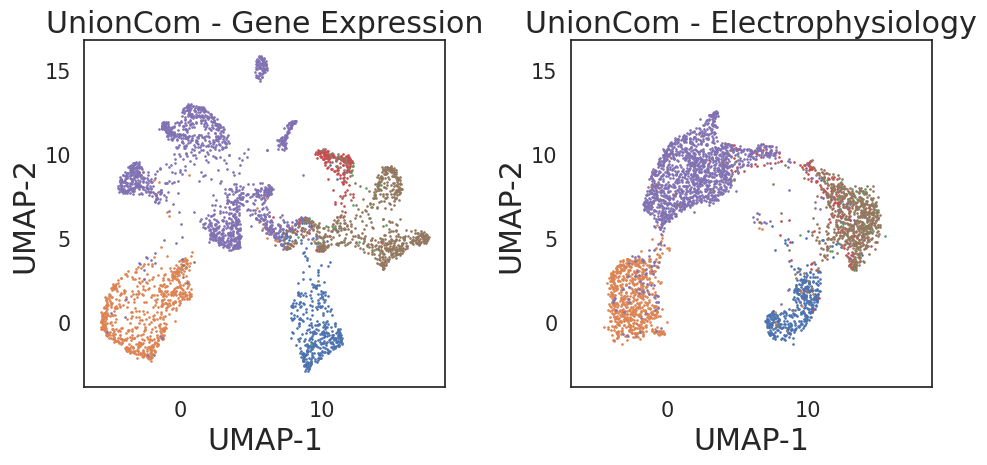

In [21]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig('./output_figures/' + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.show()

Algorithm     JAMIE      NLMA       LMA       CCA    MMD-MA  UnionCom
FOSCTTM    0.002149  0.000511  0.071707  0.247720  0.407574  0.124481
LTA        0.946360  0.947455  0.906678  0.786262  0.368637  0.887247


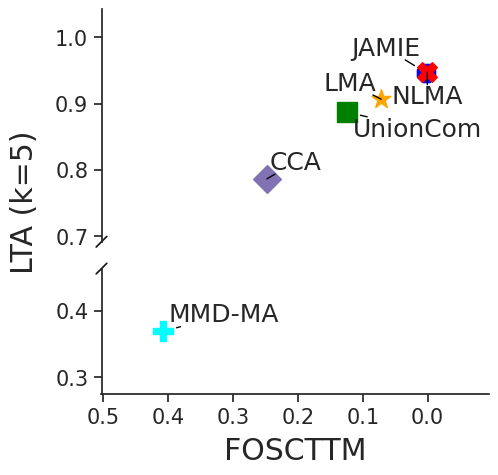

In [22]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors, shapes=shapes)
plt.savefig('./output_figures/' + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')

In [23]:
# plt.figure(figsize=(15, 5))
# plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
# sns.despine()
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Sil.png', dpi=300, bbox_inches='tight')

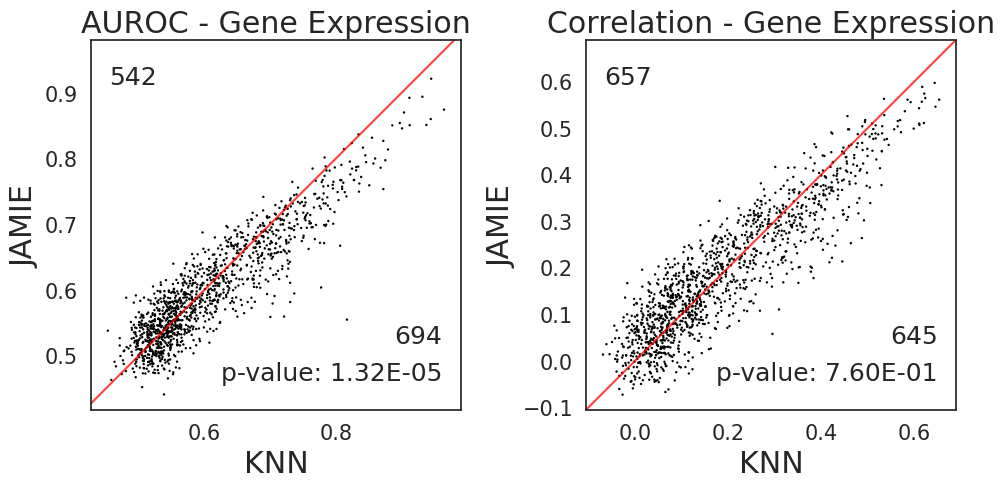

In [24]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')

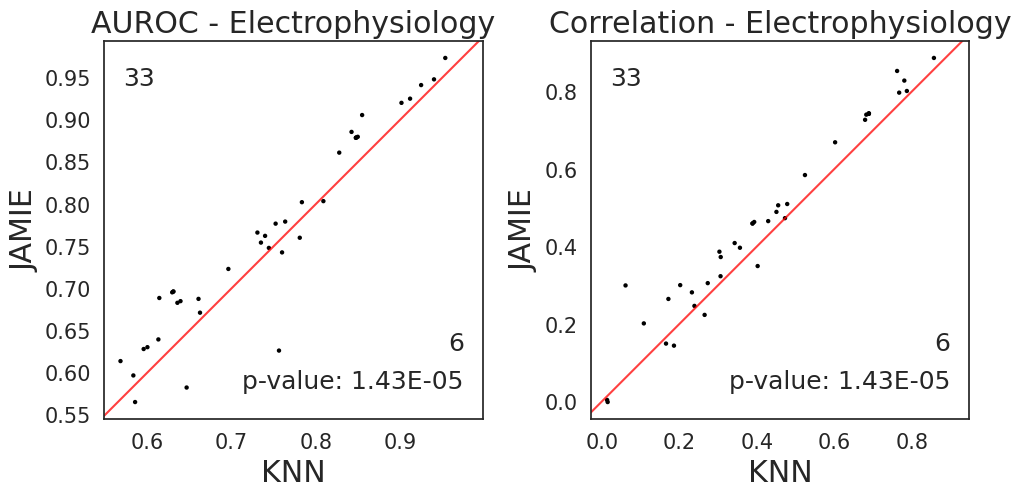

In [25]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')

Kcnc1: 0.39276709840912855
Kcnc2: 0.44766526920564464


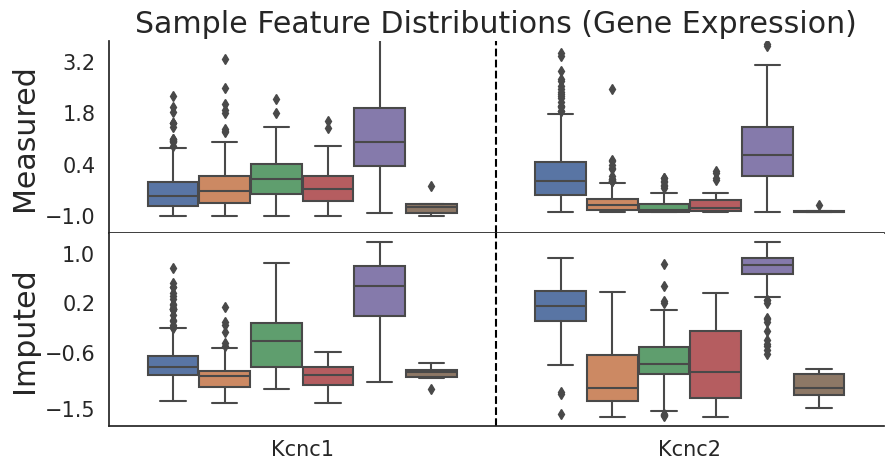

In [26]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')

threshold_i_ramp: 0.27996704492923064
threshold_t_ramp: 0.28192286414583995


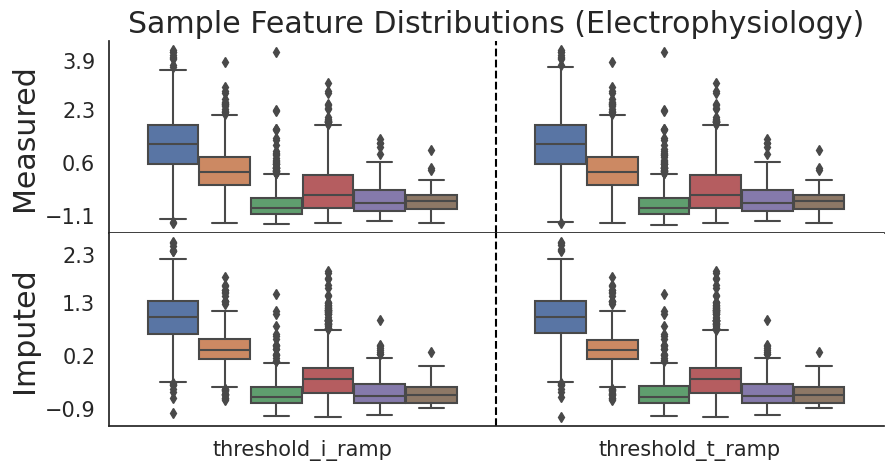

In [27]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1], jm_imputed[1]], 2*[labels[1]], title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict, remove_outliers=False)
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=axis, keepdims=True)


Mean: 0.5779205670522203
Std: 0.12111040086363326


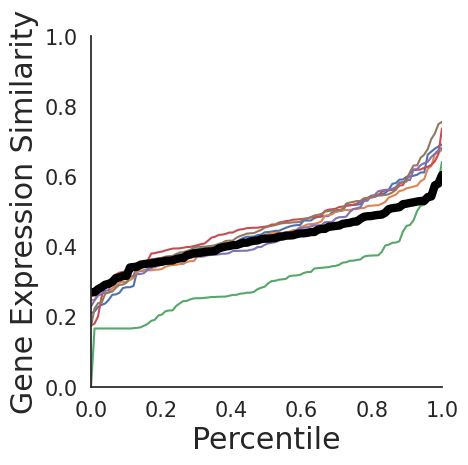

In [28]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')

Mean: 0.5367399942360072
Std: 0.11453061954732813


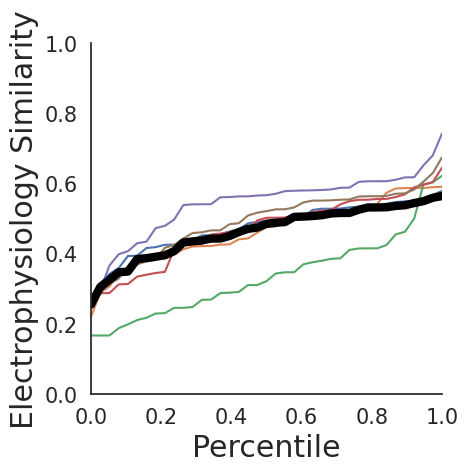

In [29]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')

# Explanation

In [30]:
mod0, mod1 = 0, 1
current_jm = jm
analysis_base = f'output_data/JAMIE---{size_str}---'
analysis_str = analysis_base + 'sorted_genes'

In [31]:
# LTA
target_name = 'LTA'
Ly = current_jm.transform_one(dataset[mod1], mod1)
function = lambda x: current_jm.test_LabelTA([current_jm.transform_one(x, mod0), Ly], labels)
perf_function = lambda x, y: x
true = None

# Imputation
# target = sort_by_interest([dataset[mod1], current_jm.modal_predict(dataset[mod0], mod0)], limit=20, remove_outliers=True)[1][1]
# target_name = features[mod1][target] + '\nCorrelation'
# function = lambda x: current_jm.modal_predict(x, mod0)[:, target]
# true = dataset[mod1][:, target]
# from scipy.stats import pearsonr
# perf_function = lambda x, y: pearsonr(x, y)[0]

testing_idx = np.array(range(dataset[mod0].shape[1]))
# testing_idx = sort_by_interest([dataset[mod0], dataset[mod0]], limit=1000, remove_outliers=False)[1]
# testing_idx = np.random.choice(dataset[mod0].shape[0], 1000, replace=False)
# scan = None
scan = 100

if not os.path.exists(analysis_str):
    baseline, performance, new_idx = evaluate_impact(function, perf_function, dataset[mod0], true, features[mod0], idx=testing_idx, scan=scan)
    argsort = np.argsort(performance)
    sorted_idx = new_idx[argsort]
    sorted_names = features[mod0][sorted_idx]
    sorted_names = np.array([s.replace(' ', '_') for s in sorted_names])
    sorted_perf = performance[argsort]
    
    file_contents = np.concatenate([sorted_idx.reshape((-1, 1)), sorted_names.reshape((-1, 1)), sorted_perf.reshape((-1, 1))], axis=1)
    file_contents_str = '\n'.join([' '.join([str(s) for s in r]) for r in file_contents]) + '\n'
    with open(analysis_str, 'w') as f:
        f.write(file_contents_str)
else:
    baseline = perf_function(function(dataset[mod0]), true)
    sorted_idx = []
    sorted_names = []
    sorted_perf = []
    with open(analysis_str, 'r') as f:
        for line in f:
            idx, names, perf = line[:-1].split(' ')
            sorted_idx.append(int(idx))
            sorted_names.append(str(names))
            sorted_perf.append(float(perf))
    sorted_idx, sorted_names, sorted_perf = np.array(sorted_idx), np.array(sorted_names), np.array(sorted_perf)
    performance = sorted_perf

In [32]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = sorted_names[:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target Electrophysiology Feature: LTA
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LTA
Important Gene Expression Features: Ankrd36, Cntn6, Pde4b, Bach1, Col19a1, Col25a1, Grid2, Penk, Cbln4, Calb1, Npy, Sst, Map9, Mgea5, Spin1, Slc4a8, Aak1, Trio, Slc6a17, Bend6
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Ankrd36
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Cntn6
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Pde4b
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Bach1
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Col19a1
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Col25a1
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Grid2
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Penk
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Cbln4
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Calb1
0.42310: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Npy
0.

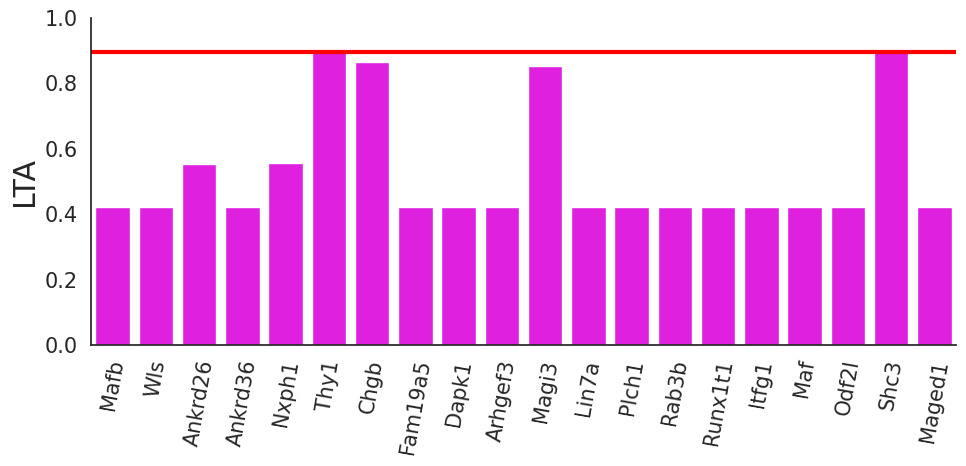

In [33]:
plt.figure(figsize=(10, 5))
plot_impact(sorted_perf, sorted_names, baseline, max_features=20, color=dataset_color)
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Analysis.png', dpi=300, bbox_inches='tight')

# SHAP

In [34]:
analysis_str = analysis_base + 'SHAP'

In [35]:
import pickle
import shap

# Subset for runtime
use_subsetting = False
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = sort_by_interest([dataset[mod1], current_jm.modal_predict(dataset[mod0], mod0)], limit=20, remove_outliers=True)[1][1]
model = lambda x: current_jm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
if not os.path.exists(analysis_str):
    explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names, seed=42)
    shap_values = explainer(data, max_evals='auto')
    with open(analysis_str, 'wb') as f:
        pickle.dump(shap_values, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(analysis_str, 'rb') as f:
         shap_values = pickle.load(f)
    print(f'Loaded data \'{analysis_str}\'')

Loaded data 'output_data/JAMIE---scMNC-Visual---3654-1302---3654-39---SHAP'


In [36]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.mean(axis=0).abs.values)[::-1][:display]]
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.max(axis=0).abs.values)[::-1][:display]]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target Electrophysiology Feature: fast_trough_t_long_square
https://www.genecards.org/cgi-bin/carddisp.pl?gene=fast_trough_t_long_square
Important Gene Expression Features: Gcc2, Cnrip1, Wasf1, Gnao1, Atp1a1, Pls3, Acsl3, Bcl11b, Rassf8, Arhgap20, Strbp, Lrrfip2, Atcay, Srrm4, Tox2, Mnat1, Ctdspl, Mboat2, Iscu, Trpm2
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Gcc2
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Cnrip1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Wasf1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Gnao1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Atp1a1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Pls3
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Acsl3
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Bcl11b
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Rassf8
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Arhgap20
https://www.genecards.org/cgi-bin/carddisp.pl?gene=Strbp
https://www.genecards.org/cgi-bin/carddisp.pl?gen

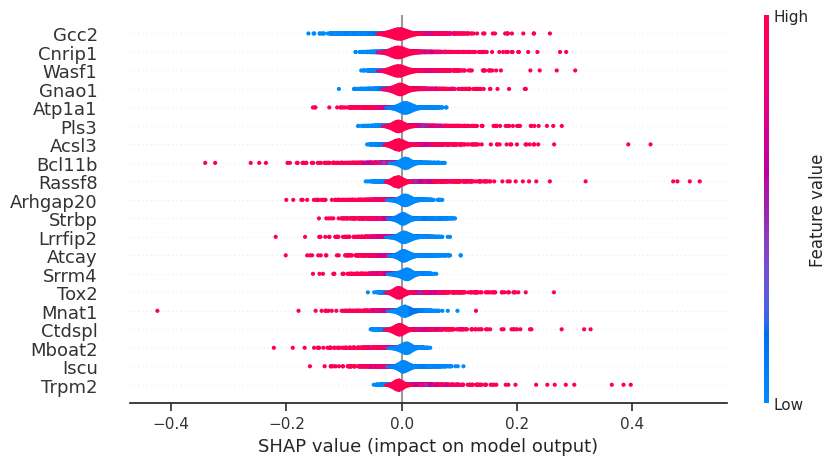

In [37]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-SHAP-Summary.png', dpi=300, bbox_inches='tight');

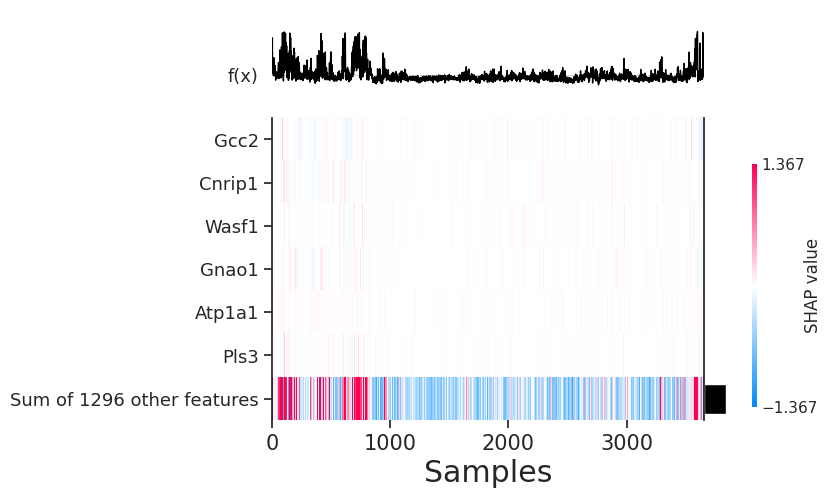

In [38]:
plt.figure(figsize=(10, 5))
shap.plots.heatmap(shap_values, max_display=7, show=False)  # 7 because problem with visualization and tight layout
plt.gca().set_xlabel('Samples')
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-SHAP-Heat.png', dpi=300, bbox_inches='tight');

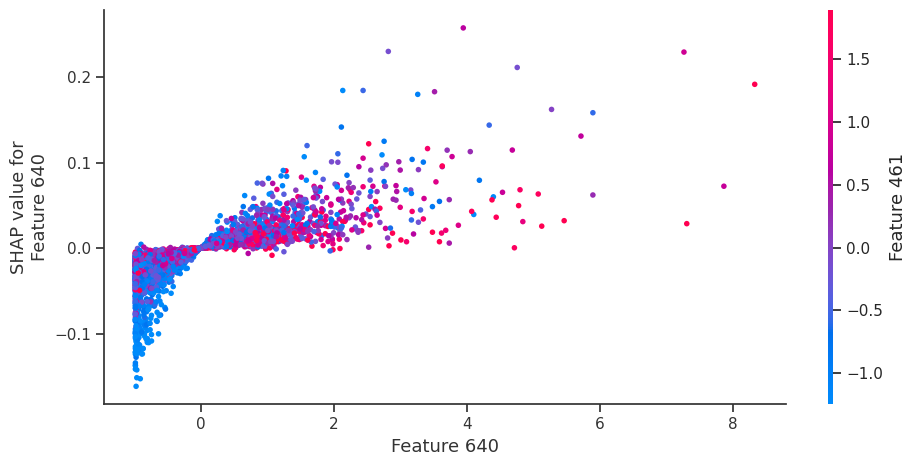

In [39]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-SHAP-Dep.png', dpi=300, bbox_inches='tight');

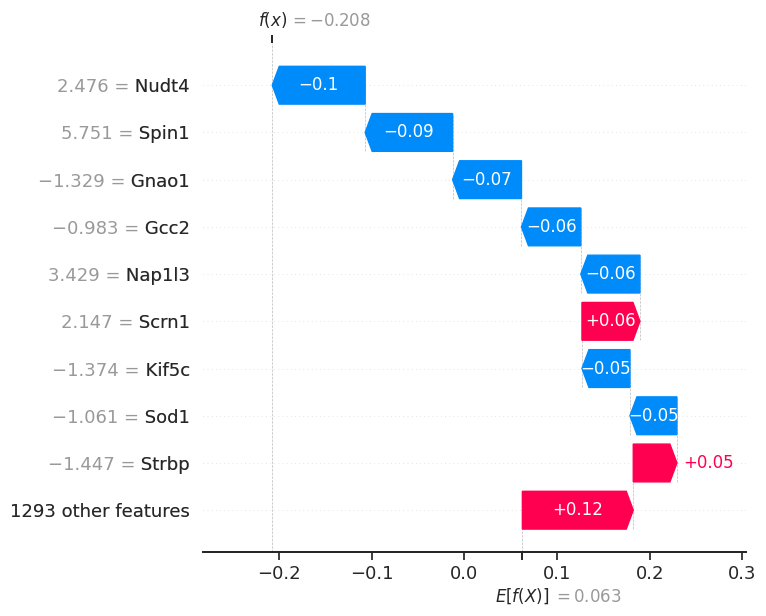

In [40]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.plots.waterfall(shap_values[0], show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-SHAP-Waterfall.png', dpi=300, bbox_inches='tight');

## Interactive

In [41]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [42]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [43]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)